In [ ]:
import requests
import json
import time
import codecs
import sys
UTF8Writer = codecs.getwriter('utf8')
sys.stdout = UTF8Writer(sys.stdout)
import re
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt

%matplotlib inline

In [76]:
def getApiKey(key_path):
    key = ""
    f = open(key_path, 'r')
    key = f.read()
    return key

Functions to clean the meetup descriptions (html tags, urls and empty lines):


In [2]:
def cleanhtml(raw_html):

  cleanr =re.compile('<.*?>') # remove html tags

  cleantext = re.sub(cleanr,'', raw_html)

  return cleantext

def clean_urls(raw_with_links): # remove url links
 
  cleantext = re.sub(r"(?:\@|https?\://)\S+", "", raw_with_links)
 
  return cleantext

def remove_empty_lines(raw_text):
  
   cleanlines=re.compile(r"[\s+]")
    #re.compile(r"^(.+?)\n\n((?:[A-Z]+\n)+)",re.MULTILINE)
   cleanempty = re.sub(cleanlines,'', raw_text)

   return cleanempty

The following function prints the descriptions on screen (1) for visual inspection or saves for later text analyis.

In [86]:
def decodeDescription(result_per_city, show_screen):
    i = 0
    description = []
    while i<len(result_per_city):
        citygroup = result_per_city[i]
        if show_screen:
            print("Name : " + citygroup['name'])
            try: 
                  print("City : "+str(citygroup['city']))
            except KeyError : 
                  print("This group has no location assigned")
            try: 
                  print("Description : "+ clean_urls(cleanhtml(citygroup['description'])))
            except KeyError : 
                  print("There is no description assigned")
        else:
            description.append(clean_urls(cleanhtml(citygroup['description'])))            
        i+=1
    
    return description


Selection of parameters for the API calls:

In [141]:
places = ["london", "berlin","barcelona", "prague", "milan", "budapest","lisboa", "amsterdam", "oslo", "copenhagen", "helsinki", "stockholm","warsaw", "paris"]
radius = 100.0 #add the radius in miles
data_format = "json"
topic = "coworking" #add your choice of topic here
per_page = 100
api_key = "add API KEY here" #or read from local file: api_key = getApiKey('path_to/api_key.txt')



Sub-function that makes the call:

In [163]:
def get_results_request(topic, radius, per_page, offset, api_key, location):
    res_request = requests.get("http://api.meetup.com/2/groups",{"sign":"true", "lon":str(location.longitude),\
             "lat":str(location.latitude), "topic": topic, "radius": str(radius), "page": per_page, \
             "offset": offset, 'key': api_key })
    
    res_request.raise_for_status() # check the response object for errors
    data_req = res_request.json()
    #print(res_request.url)
    return data_req

The main function:

In [190]:
country, city, category, rating, topics, members, geo = [], [],[],[],[],[],[]
import pandas as pd
topic = "coworking"
for place in places: 
 offset = 0
 geolocator = Nominatim()
 location = geolocator.geocode(place)
 print(location)
 
 per_page_return = per_page
    
 while (per_page_return == per_page): # make sure to fetch all the results in batches
         resjson = get_results_request(topic, radius, per_page, offset, api_key, location)
         time.sleep(3)
         offset += 1
        
         results = resjson['results']
         description = decodeDescription(results, 0) # 1- show on screen, else is saved to a string
         per_page_return = len(results) # if < per_page, it means it's the last page
         i = 0;
         while i<len(results):
                group_data = results[i]
                city.append(group_data['city'])   
                
                # there can me many topics indicated
                no_topics = len(group_data['topics'])
                
                if (no_topics > 1):
                    topics_list = []
                    for num in range(0, no_topics):
                        topics_list.append(group_data['topics'][num]['name'])

                    topics.append(topics_list)
                    
                else: 
                    topics.append(group_data['topics'][0]['name'])
                
                rating.append(group_data['rating'])
                category.append(group_data['category']['name'])
                members.append(group_data['members']) 
                country.append(group_data['country']) 
                geo.append((location.latitude, location.longitude)) 
                i+=1

 time.sleep(3)   # delays for traffic

data_final = [country, city,topics,category,members, rating, geo]
columns=['country', 'city','topics','category','members', 'rating', 'geo']   
coworking_meetup = pd.DataFrame(data_final).T
coworking_meetup.columns=columns    


London, Greater London, England, United Kingdom
Berlin, Deutschland
Barcelona, BCN, CAT, España
Praha, okres Hlavní město Praha, Hlavní město Praha, Praha, Česko
Milano, MI, LOM, Italia
Budapest, Budapesti kistérség, Budapest, Közép-Magyarország, Magyarország
Lisboa, Grande Lisboa, Lisboa, Portugal
Amsterdam, Centrum, Amsterdam, MRA, Stadsregio Amsterdam, Noord-Holland, Nederland
Oslo, Norge
København, Københavns Kommune, Region Hovedstaden, Danmark
Helsinki, Helsingin seutukunta, Uusimaa, Etelä-Suomi, Suomi
Sthlm, Stockholm, Stockholms län, Landskapet Uppland, Stockholms län, Svealand, Sverige
Warszawa, mazowieckie, Polska
Paris, Île-de-France, France métropolitaine, France


Some cleaning: 
- checking for empty cells (and removing)
- running shell script to check categories (save the file and use process_meetup_csv.sh)

In [191]:
np.where(pd.isnull(data_by_category))

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
coworking_meetup.to_csv("coworking_meetup.csv", header=True,  columns= columns)

Read in the processed data (if necessary)

In [192]:
# sum up members and join topics by categories:
data_by_category = coworking_meetup.groupby(['country','city','category']).sum()[['topics','members']]
data_by_category.head()


topics  \
country city   category                                                               
CZ      Prague career/business    [Coworking, Professional Networking, Communica...   
               games              [Coworking, Movie Nights, Texas Hold 'em, Dinn...   
DE      Berlin career/business    [Work At Home, Freelance, Coworking, Business ...   
               fine arts/culture  [Social Networking, Freelance, Crafts, Wellnes...   
               tech               [Internet Professionals, Coworking, Web Develo...   

                                  members  
country city   category                    
CZ      Prague career/business       2320  
               games                  466  
DE      Berlin career/business       3353  
               fine arts/culture      164  
               tech                   383

In [205]:
data_meetupNo = coworking_meetup.groupby(['country','city','geo', 'category']).size()
#temp.columns(['country', 'city','geo','category','topics','members'])
data_meetupNo.to_csv("data_meetupNo.csv")

Some basic plotting:

In [194]:
def make_plots(coworking_meetup, which):
    # custom colormap
    from matplotlib.colors import ListedColormap
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(121)
    if (which == 1) :
        temp = coworking_meetup.groupby('city').city.count() 
        ax1.set_xlabel('City')
        ax1.set_ylabel('number of groups in the cities')
        ax1.set_title("'coworking'groups on meetup")
    elif (which == 2) :
        temp = coworking_meetup.groupby('country').members.sum()/coworking_meetup.groupby('country').members.count()
        ax1.set_xlabel('country')
        ax1.set_ylabel('av. number of members per meetup')
        ax1.set_title("average memberships in coworking meetups across countries")
        
    else:  
        temp = coworking_meetup.groupby('country').rating.sum()/coworking_meetup.groupby('country').rating.count()
        ax1.set_xlabel('country')
        ax1.set_ylabel('av. rating per country')
        ax1.set_title("average memberships in coworking meetups across countries")
        
    temp.plot(kind='bar')




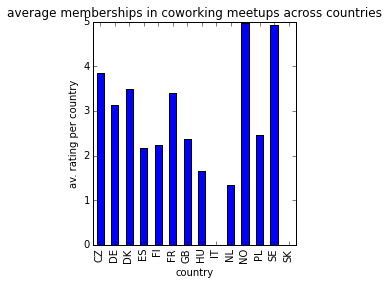

In [196]:
make_plots(coworking_meetup, 3) # options: 1-3


(The Poles people as always... not that easily pleased:))

In [180]:
# select top 10 largest (in terms of members) groups per country 
coworking_meetup.sort(['country','members'], ascending=[False,False]).head(10)

,country,city,topics,category,members,rating,geo
87,SK,Bratislava,"[Small Business, Work At Home, Freelance, Cowo...",career/business,124,0,"(47.4983815, 19.0404707)"
111,SE,Stockholm,"[Marketing, Innovation, Software Development, ...",career/business,2145,5,"(59.3251172, 18.0710935)"
106,SE,Stockholm,"[Nightlife, Social Networking, New Technology,...",tech,987,4.84,"(59.3251172, 18.0710935)"
105,SE,Stockholm,"[Web Design, Coworking, Entrepreneurship, Star...",tech,590,4.7,"(59.3251172, 18.0710935)"
107,SE,Stockholm,"[Small Business, Work At Home, Freelance, Cowo...",career/business,259,4.95,"(59.3251172, 18.0710935)"
112,SE,Uppsala,"[International and Exchange Students, Expat, L...",language/ethnic identity,184,5,"(59.3251172, 18.0710935)"
109,SE,Uppsala,"[Coworking, Professional Networking, Entrepren...",career/business,172,4.87,"(59.3251172, 18.0710935)"
108,SE,Stockholm,"[Coworking, Entrepreneurship, Co Working, Star...",career/business,133,4.93,"(59.3251172, 18.0710935)"
113,SE,Stockholm,"[Small Business, Freelance, Coworking, Young P...",career/business,128,5,"(59.3251172, 18.0710935)"
110,SE,Stockholm,"[Work At Home, Freelance, Coworking, Entrepren...",career/business,20,5,"(59.3251172, 18.0710935)"


In [207]:
data_meetupNo = coworking_meetup.groupby(['country','city','geo', 'category']).size()
#data_meetupNo.head()

country  city                      geo                           category                
CZ       Prague                    (50.0874401, 14.4212556)      career/business              4
                                                                 games                        1
DE       Berlin                    (52.5170365, 13.3888599)      career/business             10
                                                                 fine arts/culture            1
                                                                 tech                         2
         Brandenburg               (52.5170365, 13.3888599)      outdoors/adventure           1
         Düsseldorf                (52.374436, 4.8979956033677)  career/business              1
                                                                 tech                         1
         Köln                      (52.374436, 4.8979956033677)  career/business              2
DK       Copenhagen                (55.6867243

## NOTE  geo location is approximated, so a fix needed for maps
(Bergamo and Turin are too far apart to accept this inconsistency)



Text analysis on the Description data using NLTK (tokenizing, stematizing etc) + grouping by country (word cloud?) : to be done